In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #масштабирование признаков

from sklearn.metrics import confusion_matrix
import seaborn

warnings.filterwarnings('ignore')

In [137]:
df = pd.read_csv('masterskaya_id_info.csv')

In [138]:
df = df.drop('Unnamed: 0', axis=1)

In [139]:
df.head()

,id,gender,city_category,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,2020-12-30 11:42:20,2022-07-03 19:49:48,21,3500.0,166.666667,100.0,73.080738,...,43.098897,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,2019-10-11 09:03:12,2022-04-29 17:18:36,11,4200.0,381.818182,400.0,28.203597,...,108.203897,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,мужской,Город неизвестен,2022-04-07 00:00:00,2022-07-07 00:00:00,3,63.0,21.000000,16.0,0.000000,...,39.925147,0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
3,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,женский,Город неизвестен,2020-12-26 01:25:32,2022-07-26 01:25:45,18,3600.0,200.000000,200.0,26.069164,...,20.865599,2,400.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
4,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,женский,Город неизвестен,2017-08-26 18:16:27,2019-03-26 18:20:06,18,1800.0,100.000000,100.0,28.237902,...,1238.161189,2,200.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0


In [140]:
# удалим лишние столбцы
df = df.drop(['first_date', 'last_date'], axis=1)

In [141]:
df.columns.to_frame()

,0
id,id
gender,gender
city_category,city_category
donations_count,donations_count
donations_sum,donations_sum
donations_mean,donations_mean
donations_median,donations_median
last_email_activity,last_email_activity
is_reccurent,is_reccurent
lifetime,lifetime


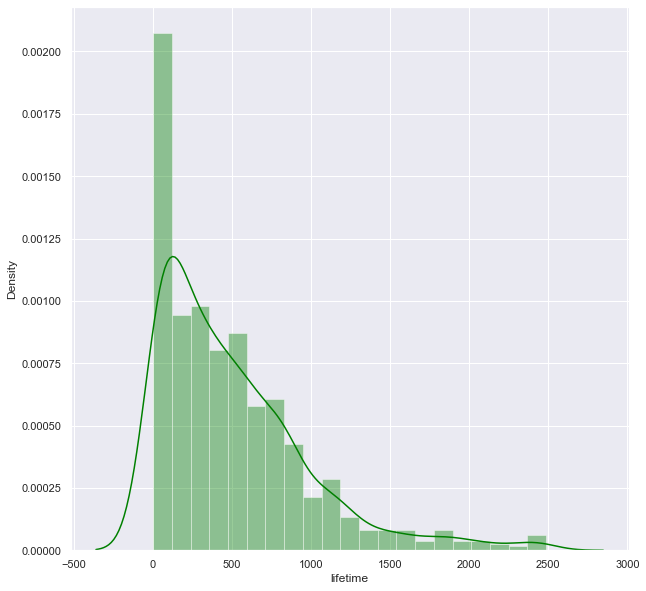

In [142]:
sns.distplot(df['lifetime'], color='green');

<AxesSubplot:>

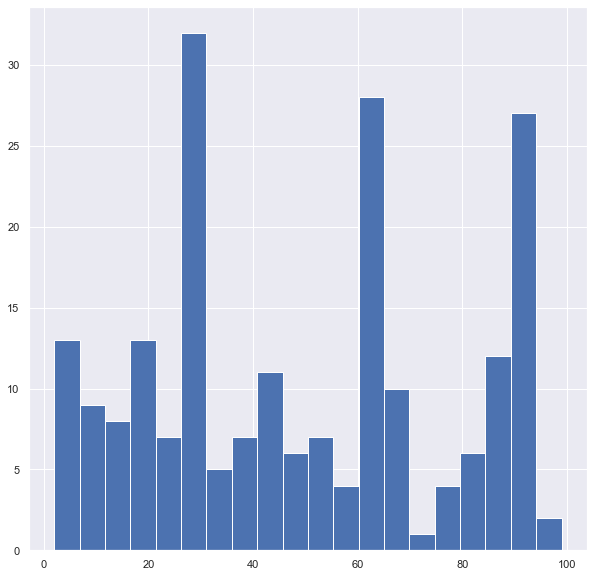

In [143]:
df[df['lifetime']<100]['lifetime'].hist(bins=20)

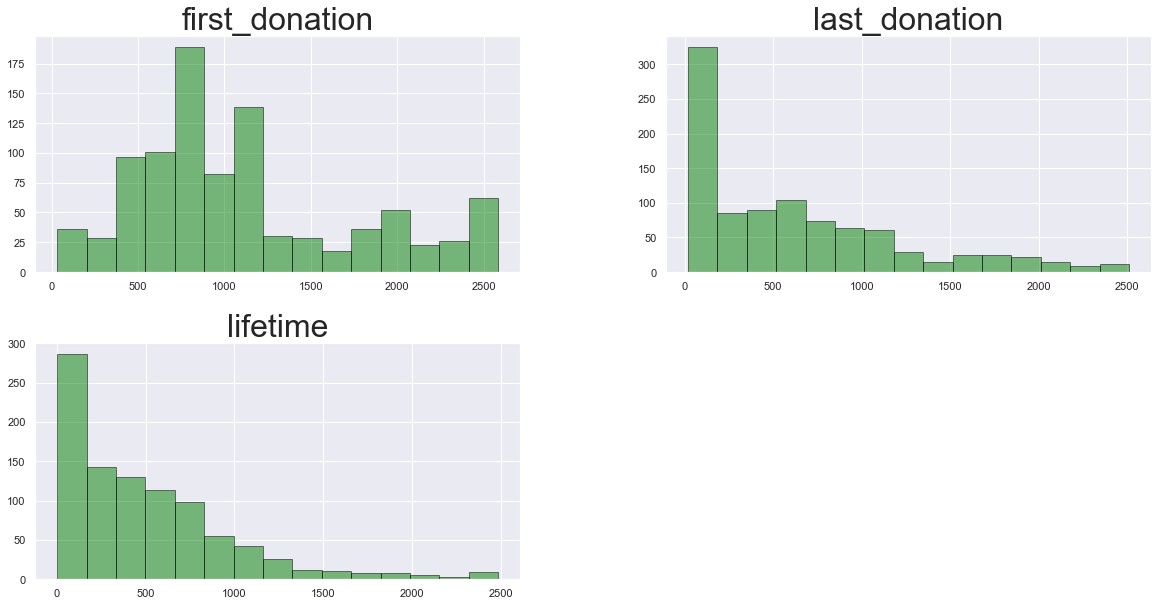

In [144]:
fig = df[['first_donation','last_donation', 'lifetime']].hist(alpha=0.5, figsize=(20,10), bins=15, fc='green',ec="black");
[x.title.set_size(32) for x in fig.ravel()];


In [145]:
print(df[df['lifetime']<100]['id'].count())
df[df['lifetime']<100].sort_values(by=['donations_median','donations_count'], ascending=False).head()

212


,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
927,54EDABBF-B115-477A-A207-1C895815005D,мужской,Другие города России,2,25500.0,12750.000000,12750.0,482.243735,0,45.0,...,490.925147,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
898,B8F67F6A-D78B-4078-9CF6-BC5F4D0E373A,мужской,Город неизвестен,2,21781.0,10890.500000,10890.5,27.919360,0,61.0,...,2401.300344,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
395,F7F24B47-3341-49EB-90D4-AC2E8F4FB320,мужской,Город неизвестен,7,57100.0,8157.142857,10510.0,27.599789,0,58.0,...,921.921282,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
586,EAD75CE6-0F33-478E-A37E-712C66DB9082,женский,Москва,4,40000.0,10000.000000,10000.0,28.237775,1,92.0,...,717.973851,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
942,D4FD3C48-37EA-439F-AAC3-59B3301DB516,женский,Город неизвестен,2,18200.0,9100.000000,9100.0,28.237763,0,20.0,...,2223.433955,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Подготовка датасета для ML

## Целевые признаки:

count_lt_diff - разность между количеством платежей за первое и последнее полугодие

total_lt_diff - разность между общей суммой пожертвований за первое и последнее полугодие

### Краткое исследование значений в  count_lt_diff и total_lt_diff

In [146]:
df[['count_lt_diff', 'total_lt_diff']].describe()

,count_lt_diff,total_lt_diff
count,949.000000,949.000000
mean,0.142255,176.566249
std,2.027187,5320.243406
min,-15.000000,-44000.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,200.000000
max,10.000000,60000.000000


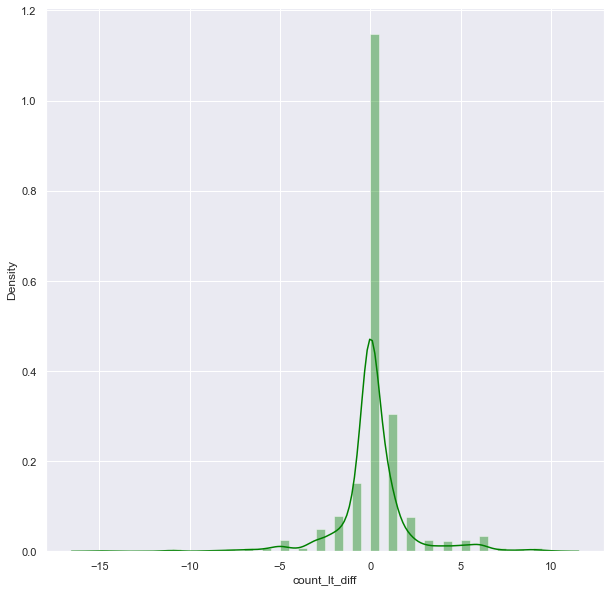

In [147]:
sns.distplot(df['count_lt_diff'], color='green');

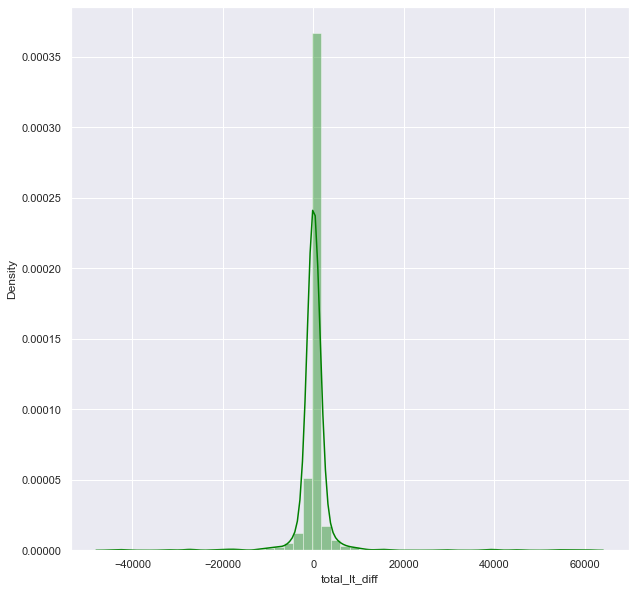

In [148]:
sns.distplot(df['total_lt_diff'], color='green')
sns.figsize = (100,100);
sns.xlim = (-2000,2000)

In [149]:
len(df['count_lt_diff'].unique())

22

In [150]:
len(df['total_lt_diff'].unique())

157

In [151]:
df['total_lt_diff'].value_counts().to_frame().head(10)

,total_lt_diff
0.0,445
500.0,34
-500.0,31
1000.0,29
100.0,26
300.0,23
-200.0,21
200.0,19
-100.0,19
-1000.0,14


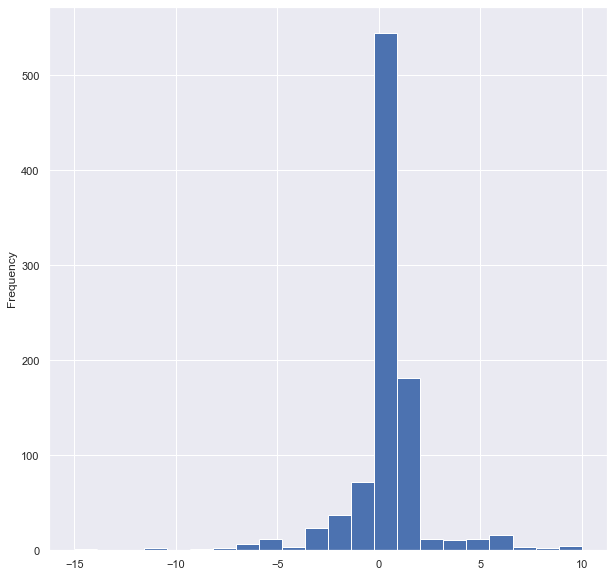

In [152]:
df['count_lt_diff'].plot(kind='hist', bins=22);

In [153]:
df['total_lt_diff'].describe().to_frame()

,total_lt_diff
count,949.000000
mean,176.566249
std,5320.243406
min,-44000.000000
25%,0.000000
50%,0.000000
75%,200.000000
max,60000.000000


## Подготовка датасета для ML

In [154]:
# классифицируем значения в столбце 'count_lt_diff'(разность между количеством пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -2 до 2 без изменений
# 1: >2 частота платежей увеличилась
# 3: <2  частота платежей уменьшилась
df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x >= -2) and (x <= 2)) else(1 if x > 2 else -1))

# классифицируем значения в столбце 'total_lt_diff'(разность между общей суммой пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -200 до 200 без изменений
# 1: >200 сумма платежей увеличилась
# 3: <200  сумма платежей уменьшилась
#df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x > -2) and (x < 2)) else(1 if x > 2 else -1))
df['total_class'] = df['total_lt_diff'].apply(lambda x: 0 if ((x >= -200) and (x <= 200)) else (1 if x >200 else -1))

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,count_class,total_class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,0,1


In [155]:
# процент лучших показателей (лучшие 11)
df[(df['total_class']==1) & (df['count_class']==1)]['id'].count()/df['id'].count()

0.05374077976817703

In [156]:
# количество лучших не ушедших жертвователей (последний платеж до полугода назад)
df[(df['total_class']==1) & (df['count_class']==1) & (df['last_donation']<182)]['id'].count()

42

In [157]:
#добавим столбец с целевым признаком
#df['class'] = 0

#for i in range(len(df['id'])):
#    if (df.loc[i]['total_class'] == 1) & (df.loc[i]['count_class'] == 1):
#        df.loc[i]['class'] = 1
#    else:
#        df.loc[i]['class'] = -1
#df.sample(2)

In [158]:
#добавим столбец с целевым признаком
df['class'] = df.count_class.map(str)\
+ df.total_class.map(str)

#удалим лишние столбцы
df = df.drop(['total_class', 'count_class'], axis=1)

df.sample(5)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
635,A9F95C12-2248-41AA-86F7-F43A71B36872,женский,Другие города России,3,150.0,50.0,50.0,0.000000,0,126.0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,00
512,EB432D3C-AB4E-4032-81F1-588DB96F4B5C,0,Москва,4,2000.0,500.0,500.0,35.104789,1,91.0,...,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,00
921,0B1155F6-D025-41EA-B9D8-BF8C1F0064DC,женский,Другие города России,2,300.0,150.0,150.0,0.000000,0,37.0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,00
342,F4468D65-4F33-4431-BAFD-68E80590D4C2,женский,Город неизвестен,8,4000.0,500.0,500.0,27.575900,1,214.0,...,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,00
206,0BB2E63C-07CD-4008-9ADD-2F13AFCEE950,женский,Город неизвестен,19,1900.0,100.0,100.0,28.237763,1,549.0,...,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,00


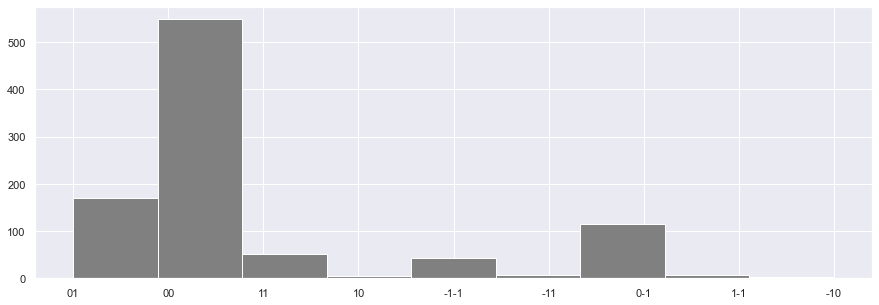

In [159]:
df['class'].hist(bins=9, figsize = (15,5), color='gray');

In [160]:
df['class'].unique()

array(['01', '00', '11', '10', '-1-1', '-11', '0-1', '1-1', '-10'],
      dtype=object)

In [161]:
df[df['class']=='-11']

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
37,E85E70D9-6809-4E1C-AE25-0EC489934DDC,мужской,Москва,34,4300.0,126.470588,100.0,28.237775,1,1813.0,...,-3,600.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
134,193FBEF8-9C3E-4581-BBDF-A5D3EF653AE1,мужской,Москва,62,34500.0,556.451613,500.0,28.237798,1,2009.0,...,-3,500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
164,07923DBB-392D-4448-8117-E769F52AA476,женский,Город неизвестен,34,20300.0,597.058824,300.0,28.237763,1,1342.0,...,-3,9200.0,0.970588,0.0,0.029412,0.000000,1.000000,0.0,0.000000,-11
179,22BDC942-B82B-4004-ADFC-7787F780FB60,мужской,Москва,8,2125.0,265.625000,100.0,28.237775,1,551.0,...,-4,525.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
226,64AE2C89-F75D-46C4-811C-CF199C3A43C9,женский,Другие города России,33,8300.0,251.515152,200.0,27.838608,1,2397.0,...,-4,800.0,0.969697,0.0,0.000000,0.030303,0.969697,0.0,0.030303,-11
234,69613503-5B71-4690-ACB5-8E783FF915B4,мужской,Город неизвестен,23,15500.0,673.913043,500.0,0.000000,0,462.0,...,-3,1500.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,-11
654,214CC544-A5CE-4E6E-B3BD-B2CC5396C5A0,женский,Город неизвестен,13,26500.0,2038.461538,1000.0,28.237775,1,1010.0,...,-5,8500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11


In [162]:
# разобьем жертвователей на 4 класса
# - 1 -- уменьшившие сумму и/или частоту пожертвований;
# 0 -- не изменившие сумму и частоту пожертвований;
# 1 -- увеличившие сумму или частоту пожертвований;
# 2 -- увеличившие сумму и частоту пожертвований

df['class'] = df['class'].replace(['11'],2)
df['class'] = df['class'].replace(['01','10','-11','1-1'],1)
df['class'] = df['class'].replace('00', 0)
df['class'] = df['class'].replace(['-1-1','-10','0-1'],-1)
df['class'].unique()

array([ 1,  0,  2, -1])

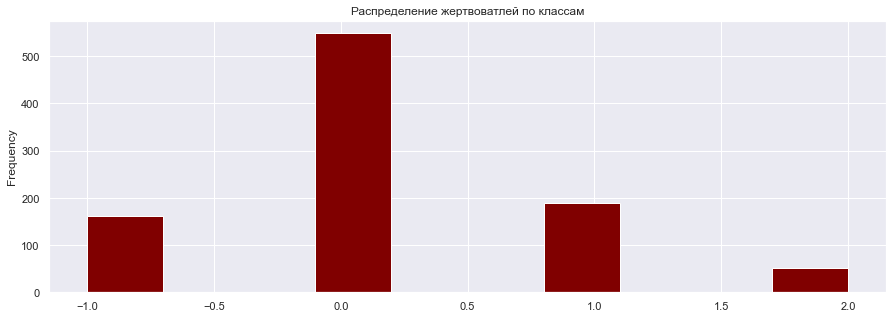

In [163]:
df['class'].plot(title='Распределение жертвоватлей по классам', kind='hist', figsize=(15,5), color='maroon');

In [164]:
df['class'].value_counts().to_frame()

,class
0,548
1,188
-1,162
2,51


## Подготовим выборки для ML

## Кодирование

In [165]:
df.columns

Index(['id', 'gender', 'city_category', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'lifetime', 'period', 'first_donation', 'last_donation',
       'count_lt_diff', 'total_lt_diff', 'пожертвование', 'sms_purpose',
       'именное пожертвование', 'назнчение не указано', 'банковские карты',
       'sms_channel', 'прямые поступления на счет', 'class'],
      dtype='object')

In [166]:
columns = ['is_reccurent', 
       'gender', 
       'city_category']

for i in columns:
    df[i] = (df[i]).astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          949 non-null    object  
 1   gender                      949 non-null    category
 2   city_category               949 non-null    category
 3   donations_count             949 non-null    int64   
 4   donations_sum               949 non-null    float64 
 5   donations_mean              949 non-null    float64 
 6   donations_median            949 non-null    float64 
 7   last_email_activity         949 non-null    float64 
 8   is_reccurent                949 non-null    category
 9   lifetime                    949 non-null    float64 
 10  period                      949 non-null    float64 
 11  first_donation              949 non-null    float64 
 12  last_donation               949 non-null    float64 
 13  count_lt_diff       

In [167]:
for i in columns:
    df[i] = (df[i]).cat.codes

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,1,3,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,1,3,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,1


In [168]:
df = df.drop(['id', 'total_lt_diff','count_lt_diff'], axis=1)

### Новые жертвователи
Условия:
* первый платеж совершен от полугода до года назад.

Для этих пользователей предскажем дальнейшее поведение.

In [169]:
# выделим из датасета новых жертвователей (первый платеж от полугода до года назад)
df_new = df[(df['first_donation']>=182) & (df['first_donation']<=365)]
# удалим столбец с целевым признаком ('class'), предварительно сохранив его
class_new = df_new['class']
df_new = df_new.drop('class',axis=1)
print('Доля новых жертвователей: ', len(df_new['first_donation'])/len(df['first_donation']))
df_new.sample(3)

Доля новых жертвователей:  0.03161222339304531


,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
717,0,3,2,2000.0,1000.0,1000.0,28.237798,0,90.0,45.0,279.074129,188.408944,1.0,0.0,0.0,0.0,1.0,0.0,0.0
904,1,1,2,1000.0,500.0,500.0,0.000000,0,174.0,87.0,268.925147,94.925147,0.0,0.0,0.0,1.0,0.0,0.0,1.0
669,1,3,5,2200.0,440.0,400.0,0.000000,0,218.0,43.6,268.925147,50.925147,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [170]:
df_new.describe()

,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,1.000000,1.400000,5.233333,4166.033333,661.921789,647.433333,24.808263,0.300000,161.733333,35.816609,289.253406,127.325478,0.851515,0.012121,0.0,0.136364,0.587879,0.012121,0.400000
std,0.643268,1.302517,3.318530,8341.454866,931.497631,950.403750,50.072459,0.466092,103.674202,29.382898,48.989612,103.501033,0.346364,0.066391,0.0,0.344934,0.492597,0.066391,0.498273
min,0.000000,0.000000,2.000000,60.000000,10.000000,10.000000,0.000000,0.000000,13.000000,4.750000,185.925147,20.365541,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,731.250000,276.136364,300.000000,0.000000,0.000000,56.500000,23.550000,263.675147,41.732960,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,1600.000000,420.000000,400.000000,25.644256,0.000000,192.000000,27.400000,295.824279,90.701571,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,8.750000,3750.000000,731.250000,612.500000,28.237786,1.000000,255.500000,42.807143,330.923559,203.046097,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
max,2.000000,3.000000,11.000000,45000.000000,5000.000000,5000.000000,280.114557,1.000000,305.000000,130.000000,363.960738,330.925147,1.000000,0.363636,0.0,1.000000,1.000000,0.363636,1.000000


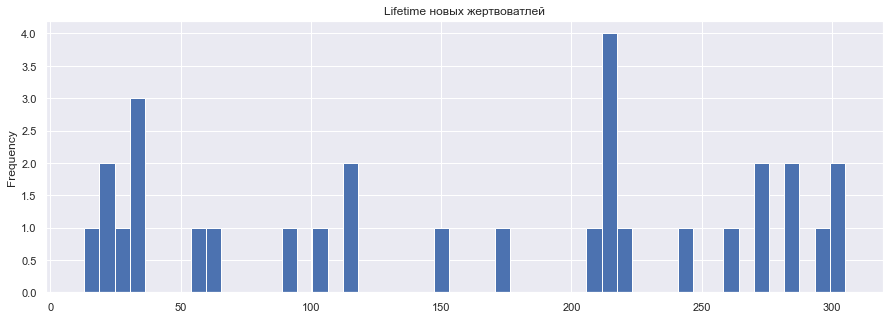

In [171]:
df_new['lifetime'].plot(title='Lifetime новых жертвоватлей', figsize=(15,5), kind='hist', bins=50);

In [172]:
# удалим новых жертвователей из основного датасета
df = df[df['first_donation']>365]

In [173]:
# разделим данные на выборки
target = df['class']
features = df.drop('class', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=12345)

In [177]:
# функция для вычисления метрик
def accuracy(model):
    predictions = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions, target_test))
    
    # confusion_matrix
    seaborn.heatmap(confusion_matrix(predictions, target_test)/len(target_test), annot=True, square=True)
    sns.set(rc = {'figure.figsize':(10,10)})
    plt.title('Матрица ошибок на тестовой выборке', y=1.05, size=15);
   
   
    # roc auc
    predict_proba = model.predict_proba(features_test)
    predict_proba = predict_proba[:, 1]
    predict_proba = np.array(predict_proba)
   # print('ROC AUC:', roc_auc_score(predictions, target_test, multi_class="ovr"))
    
    
    # основные метрики при помощи classification_report
    print(classification_report(predictions, target_test))


### CatBoost

In [ ]:
%%time
model1_grid = CatBoostClassifier(random_state = 12345, verbose=0)

parameters = {'depth': [5, 10],
                 'learning_rate': [0.02,0.04],
                  'iterations': [50, 100]
                 }

grid = GridSearchCV(estimator=model1_grid, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

Accuracy: 0.6440677966101694
              precision    recall  f1-score   support

          -1       0.46      0.32      0.38        37
           0       0.82      0.88      0.85        96
           1       0.43      0.43      0.43        37
           2       0.17      0.29      0.21         7

    accuracy                           0.64       177
   macro avg       0.47      0.48      0.47       177
weighted avg       0.64      0.64      0.64       177



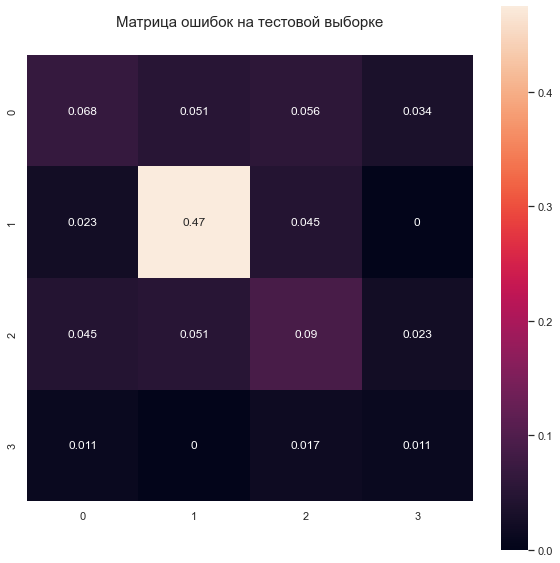

In [178]:
# CatBoost

#выделим категориальные признаки для бустинга
cat_features = ['is_reccurent',  'gender']

model1 = CatBoostClassifier(iterations=150, random_state = 12345)
model1.fit(features_train, target_train, cat_features=cat_features, verbose=0)
accuracy(model1)

### RandomForest

In [ ]:
%%time
model_2_grid = RandomForestClassifier()

parametrs = {'n_estimators': range (1,20,2),
              'max_depth': range (2,20,2),
              }

grid = GridSearchCV(model_2_grid, parametrs, cv=5, scoring='accuracy')
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

Accuracy: 0.6836158192090396
              precision    recall  f1-score   support

          -1       0.42      0.32      0.37        34
           0       0.88      0.84      0.86       107
           1       0.46      0.57      0.51        30
           2       0.25      0.50      0.33         6

    accuracy                           0.68       177
   macro avg       0.50      0.56      0.52       177
weighted avg       0.70      0.68      0.69       177



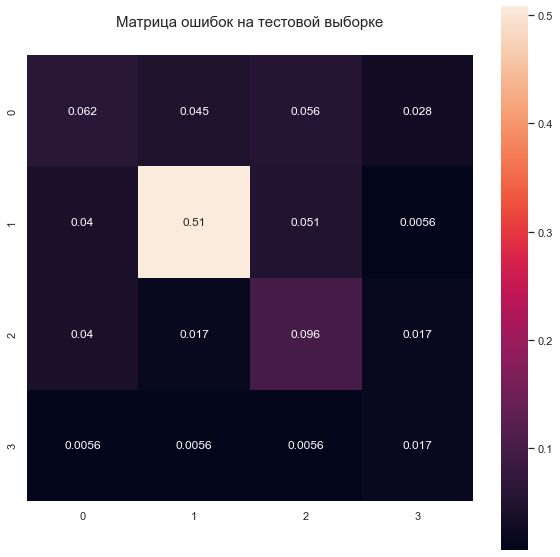

In [179]:
model2 = RandomForestClassifier(n_estimators=109, max_depth=30)
model2.fit(features_train, target_train)
accuracy(model2)


In [180]:
# обучим и проверим модели на другой выборке

In [181]:
features_train2, features_test2, target_train2, target_test2 = train_test_split(
    features, target, 
    test_size=0.4, 
    random_state=12345)

In [182]:
# функция для предсказания и вычисления accucacy по второму разделению на выборки
def accuracy2(model):
    predictions2 = model.predict(features_test2)
    print('Accuracy:', accuracy_score(predictions2, target_test2))

In [183]:
model12 = CatBoostClassifier(iterations=150, random_state = 12345,verbose=0)
model12.fit(features_train2, target_train2, cat_features=cat_features, verbose=0)
accuracy2(model12)

Accuracy: 0.6694915254237288


In [184]:
model22 = RandomForestClassifier()
model22.fit(features_train2, target_train2)
accuracy2(model22)

Accuracy: 0.6807909604519774


### Проверка на случайной выборке

In [185]:
target_random = []
for i in range(len(target_test)):
    target_random.append(0)


def accuracy_random(model):
    predictions_random = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions_random, target_random))

In [186]:
accuracy_random(model1)

Accuracy: 0.5423728813559322


In [187]:
accuracy_random(model2)

Accuracy: 0.6045197740112994


### Кросс-валидация

In [188]:
# кросс-валидация
from sklearn.model_selection import cross_val_score # кросс-валидация
from sklearn.metrics import make_scorer
#accuracy_score = make_scorer(accuracy)
scores = sum(cross_val_score(model12, features, target, cv=5))/5
scores

0.6587570621468927

### Классификация новых жертвователей

In [189]:
predictions_new = model1.predict(df_new)

In [190]:
df_new['class_predict'] = predictions_new
df_new['class'] = class_new
df_new

,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,...,last_donation,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class_predict,class
61,1,1,10,3000.0,300.000000,300.0,28.237786,1,273.0,27.300000,...,47.543400,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1,0
86,0,3,4,9000.0,2250.000000,2500.0,280.114557,0,19.0,4.750000,...,297.431548,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,0
122,2,1,3,715.0,238.333333,150.0,0.000000,0,33.0,11.000000,...,265.925147,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.0,0,0
167,2,3,4,2000.0,500.000000,500.0,28.237983,0,118.0,29.500000,...,86.477995,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,0
200,1,1,9,4500.0,500.000000,500.0,24.343608,1,242.0,26.888889,...,41.335564,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1,0
217,1,0,11,11000.0,1000.000000,1000.0,0.000000,0,298.0,27.090909,...,42.925147,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1,0
281,1,3,3,900.0,300.000000,300.0,28.237786,0,33.0,11.000000,...,311.996502,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,0
344,1,1,8,5400.0,675.000000,650.0,0.000000,0,210.0,26.250000,...,61.925147,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.0,1,1
383,1,1,11,10000.0,909.090909,500.0,24.287196,1,273.0,24.818182,...,28.226895,0.909091,0.000000,0.0,0.090909,1.000000,0.000000,0.0,1,1
427,1,0,5,1700.0,340.000000,300.0,0.000000,0,117.0,23.400000,...,142.925147,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0,0


In [191]:
# точность предсказания классов для новых жертвователей
accuracy_score(predictions_new, df_new['class'])

0.6

**Вывод:** предсказанный моделью класс совпадает с установленным по признакам на 60%.

In [192]:
pd.Series(model1.feature_importances_, index=df.drop('class', axis=1).columns).sort_values(ascending=False).to_frame()

,0
period,15.026231
lifetime,12.362933
last_donation,11.912192
donations_count,9.914011
donations_mean,9.884129
donations_sum,9.604531
last_email_activity,6.420880
first_donation,6.249157
gender,4.350299
city_category,4.304683


In [193]:
predictions_proba_new = model1.predict_proba(df_new)

### Confusion Matrix

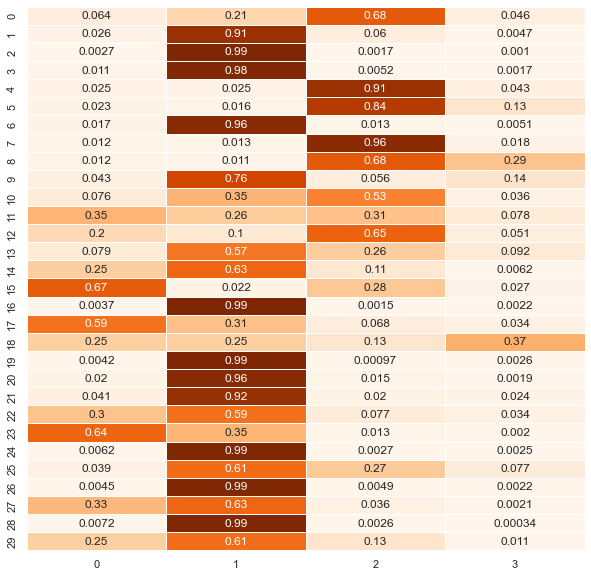

In [194]:
seaborn.heatmap(predictions_proba_new, 
                annot=True, 
                linewidths=.5, 
                cmap='Oranges',
                cbar=False
               )
sns.set(rc = {'figure.figsize':(10,15)});

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix(predictions_new, df_new['class'])
#seaborn.heatmap(confusion_matrix(predictions_new, df_new['class']))
#sns.set(rc = {'figure.figsize':(10,10)});

array([[ 0,  3,  1,  0],
       [ 1, 16,  1,  0],
       [ 1,  4,  2,  0],
       [ 0,  1,  0,  0]])

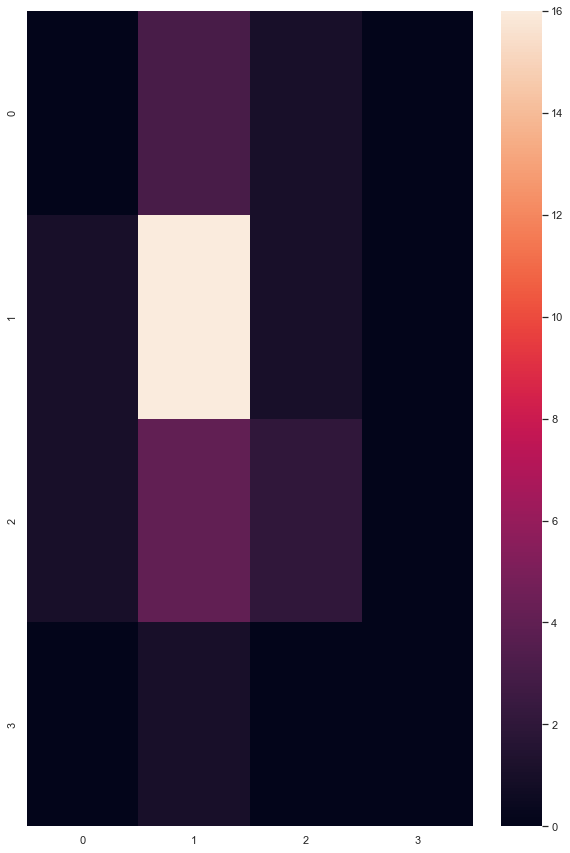

In [196]:
seaborn.heatmap(confusion_matrix(predictions_new, df_new['class']))
sns.set(rc = {'figure.figsize':(10,10)});

### ROC AUC
для новых жертвователей

predictions_proba_new = model1.predict_proba(df_new)
probabilities_one = predictions_proba_new[:, 1]
auc_roc = roc_auc_score(df_new['class'], probabilities_one, multi_class='ovo')


# Вариант 2

Удалим из обучающей выборки столбцы, значения которых связано с длительностью пожертвований и столбцы, т.к. эти значения могут негативно влиять на качество предсказания.


In [197]:
df = df.drop(['donations_sum', 'donations_count', 'first_donation', 'last_donation'], axis=1)

In [198]:
# разделим данные на выборки
target = df['class']
features = df.drop('class', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=12345)

### RandomForest

In [202]:
%%time
model_3_grid = RandomForestClassifier()

parametrs = {'n_estimators': range (1,20,2),
              'max_depth': range (2,20,2),
              }

grid = GridSearchCV(model_3_grid, parametrs, cv=5, scoring='accuracy')
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 8, 'n_estimators': 13}
0.6723104584956546
CPU times: user 10.8 s, sys: 169 ms, total: 10.9 s
Wall time: 11 s


Accuracy: 0.7231638418079096
              precision    recall  f1-score   support

          -1       0.46      0.39      0.42        31
           0       0.89      0.84      0.87       108
           1       0.57      0.66      0.61        32
           2       0.33      0.67      0.44         6

    accuracy                           0.72       177
   macro avg       0.56      0.64      0.59       177
weighted avg       0.74      0.72      0.73       177



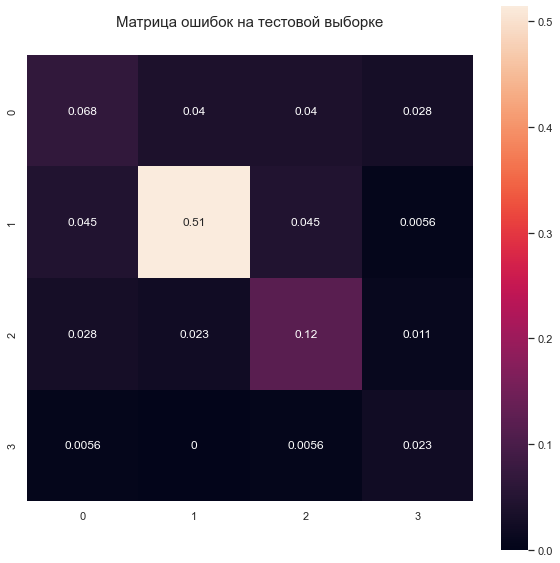

In [200]:
model3 = RandomForestClassifier(max_depth = 8, n_estimators = 13)
model3.fit(features_train, target_train)
accuracy(model3)

### CatBoost

In [204]:
%%time
model4_grid = CatBoostClassifier(random_state = 12345, verbose=0)

parameters = {'depth': [5, 10],
                 'learning_rate': [0.02,0.04],
                  'iterations': [50, 100]
                 }

grid = GridSearchCV(estimator=model4_grid, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

{'depth': 5, 'iterations': 100, 'learning_rate': 0.04}
0.6327683615819208
CPU times: user 533 ms, sys: 135 ms, total: 668 ms
Wall time: 18.7 s


Accuracy: 0.672316384180791
              precision    recall  f1-score   support

          -1       0.42      0.34      0.38        32
           0       0.88      0.82      0.85       110
           1       0.49      0.51      0.50        35
           2       0.00      0.00      0.00         0

    accuracy                           0.67       177
   macro avg       0.45      0.42      0.43       177
weighted avg       0.72      0.67      0.70       177



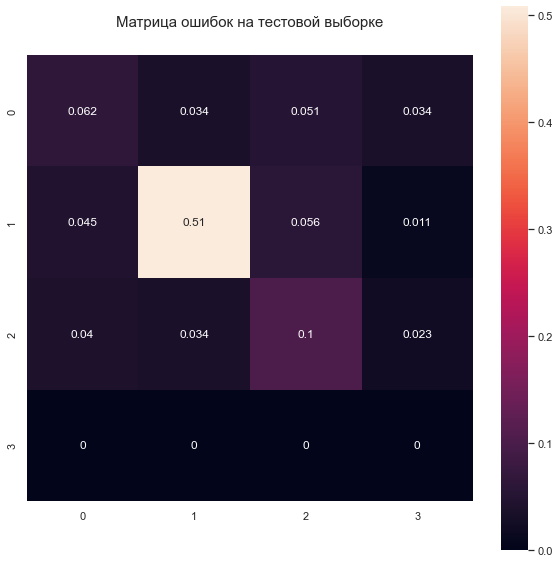

In [205]:
# CatBoost

model4 = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.04, random_state = 12345)
model4.fit(features_train, target_train, cat_features=cat_features, verbose=0)
accuracy(model4)